In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import torch
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import torch.nn.functional as F
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *

In [4]:
from lib import common

In [5]:
pd.options.mode.chained_assignment = None

### Path

In [6]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

In [7]:
model_path = Path('/kaggle/osic_pulmonary/model')
if os.path.isdir(model_path) == False:
    os.makedirs(model_path)
assert model_path.exists()

### Read Data

In [8]:
train_df, test_df, submission_df = common.read_data(path)

#### Feature generation

In [9]:
len(train_df)

1542

In [10]:
submission_df = common.prepare_submission(submission_df, test_df)

In [11]:
submission_df[((submission_df['Patient'] == 'ID00419637202311204720264') & (submission_df['Weeks'] == 6))].head(25)

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
18,ID00419637202311204720264,6,100,ID00419637202311204720264_6,3020,70.186852,73,Male,Ex-smoker


In [12]:
def adapt_percent_in_submission():
    previous_match = None
    for i, r in submission_df.iterrows():
        in_training = train_df[(train_df['Patient'] == r['Patient']) & (train_df['Weeks'] == r['Weeks'])]
        if(len(in_training) > 0):
            previous_match = in_training['Percent'].item()
            submission_df.iloc[i, submission_df.columns.get_loc('Percent')] = previous_match
        elif previous_match is not None:
            submission_df.iloc[i, submission_df.columns.get_loc('Percent')] = previous_match

In [13]:
adapt_percent_in_submission()

In [14]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045288,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258904,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824966,73,Male,Never smoked


In [15]:
test_df[test_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker


In [16]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186852,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445107,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678810,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632984,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610394,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935764,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911224,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377335,73,Male,Ex-smoker


In [17]:
submission_df[submission_df['Patient'] == 'ID00419637202311204720264'].head(10)

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186852,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186852,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186852,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186852,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186852,73,Male,Ex-smoker
5,ID00419637202311204720264,-7,100,ID00419637202311204720264_-7,3020,70.186852,73,Male,Ex-smoker
6,ID00419637202311204720264,-6,100,ID00419637202311204720264_-6,3020,70.186852,73,Male,Ex-smoker
7,ID00419637202311204720264,-5,100,ID00419637202311204720264_-5,3020,70.186852,73,Male,Ex-smoker
8,ID00419637202311204720264,-4,100,ID00419637202311204720264_-4,3020,70.186852,73,Male,Ex-smoker
9,ID00419637202311204720264,-3,100,ID00419637202311204720264_-3,3020,70.186852,73,Male,Ex-smoker


Adding missing values

In [18]:
train_df['WHERE'] = 'train'
test_df['WHERE'] = 'val'
submission_df['WHERE'] = 'test'
data = train_df.append([test_df, submission_df])

In [19]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [20]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC', 'Percent']].copy()
base.columns = ['Patient','min_FVC', 'min_Percent']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base

,Patient,min_FVC,min_Percent,nb
0,ID00007637202177411956430,2315,58.253647,1
9,ID00009637202177434476278,3660,85.282875,1
18,ID00010637202177584971671,3523,94.724670,1
27,ID00011637202177653955184,3326,85.987587,1
36,ID00012637202177665765362,3418,93.726006,1
...,...,...,...,...
1504,ID00419637202311204720264,3020,70.186852,1
1513,ID00421637202311550012437,2739,82.045288,1
1523,ID00422637202311677017371,1930,76.672493,1
1531,ID00423637202312137826377,3294,79.258904,1


In [21]:
data = data.merge(base, on='Patient', how='left')

In [22]:
data['base_week'] = data['Weeks'] - data['min_week']
data['base_week'] = data['base_week']
del base

In [23]:
data[data['Patient'] == 'ID00421637202311550012437']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,min_Percent,nb,base_week
1507,ID00421637202311550012437,15,2739,82.045288,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,0.0
1508,ID00421637202311550012437,17,2756,82.554520,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,2.0
1509,ID00421637202311550012437,19,2755,82.524559,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,4.0
1510,ID00421637202311550012437,21,2820,84.471603,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,6.0
1511,ID00421637202311550012437,23,2853,85.460098,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,ID00421637202311550012437,129,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_129,15.0,2739,82.045288,1,114.0
1835,ID00421637202311550012437,130,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_130,15.0,2739,82.045288,1,115.0
1836,ID00421637202311550012437,131,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_131,15.0,2739,82.045288,1,116.0
1837,ID00421637202311550012437,132,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_132,15.0,2739,82.045288,1,117.0


In [24]:
COLS = ['Sex','SmokingStatus'] #,'Age', 'Sex_SmokingStatus'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [25]:
data[data['Patient'] == 'ID00421637202311550012437']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,min_Percent,nb,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes
1507,ID00421637202311550012437,15,2739,82.045288,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,0.0,1,0,1,0,0
1508,ID00421637202311550012437,17,2756,82.554520,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,2.0,1,0,1,0,0
1509,ID00421637202311550012437,19,2755,82.524559,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,4.0,1,0,1,0,0
1510,ID00421637202311550012437,21,2820,84.471603,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,6.0,1,0,1,0,0
1511,ID00421637202311550012437,23,2853,85.460098,68,Male,Ex-smoker,train,NaN,NaN,15.0,2739,82.045288,1,8.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,ID00421637202311550012437,129,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_129,15.0,2739,82.045288,1,114.0,1,0,1,0,0
1835,ID00421637202311550012437,130,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_130,15.0,2739,82.045288,1,115.0,1,0,1,0,0
1836,ID00421637202311550012437,131,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_131,15.0,2739,82.045288,1,116.0,1,0,1,0,0
1837,ID00421637202311550012437,132,2739,78.720345,68,Male,Ex-smoker,test,100.0,ID00421637202311550012437_132,15.0,2739,82.045288,1,117.0,1,0,1,0,0


In [26]:
np.mean(np.abs(data['Age'] - data['Age'].mean())), data['Age'].mad()

(4.924904657504615, 4.924904657504615)

In [27]:
def normalize(df:pd.DataFrame, cont_names, target_names):
    "Compute the means and stds of `self.cont_names` columns to normalize them."
    means, stds = {},{}
    for n, t in zip(cont_names, target_names):
        means[n], stds[n] = df[n].mean(), df[n].std()
#         means[n], stds[n] = df[n].mean(), df[n].mad()
        df[t] = (df[n]-means[n]) / (1e-7 + stds[n])

normalize(data, ['Age','min_FVC','base_week','Percent', 'min_Percent', 'min_week'], ['age','BASE','week','percent', 'min_percent', 'min_week'])
FE += ['age','week','BASE', 'percent']

In [28]:
data['base_week'].min()

-29.0

In [29]:
train_df = data.loc[data.WHERE=='train']
test_df = data.loc[data.WHERE=='val']
submission_df = data.loc[data.WHERE=='test']
del data

In [30]:
train_df.sort_values(['Patient', 'Weeks']).head(15)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent,min_percent
0,ID00007637202177411956430,-4,2315,58.253647,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.876378,-0.970624,-1.275371
1,ID00007637202177411956430,5,2214,55.712128,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.598597,-1.118062,-1.275371
2,ID00007637202177411956430,7,2061,51.862103,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.536868,-1.341409,-1.275371
3,ID00007637202177411956430,9,2144,53.950680,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.475140,-1.220247,-1.275371
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.413411,-1.329731,-1.275371
5,ID00007637202177411956430,17,2101,52.868645,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,-0.228224,-1.283018,-1.275371
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,0.142150,-1.430455,-1.275371
7,ID00007637202177411956430,41,2064,51.937595,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,0.512524,-1.337029,-1.275371
8,ID00007637202177411956430,57,2057,51.761448,79,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,1.638237,-0.636809,1.006356,-1.347248,-1.275371
9,ID00009637202177434476278,8,3660,85.282875,69,Male,Ex-smoker,train,NaN,NaN,...,1,0,1,0,0,0.050822,1.186333,-0.876378,0.597388,0.385378


In [31]:
X = train_df[FE]
X.head(15)

,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,week,BASE,percent
0,1,0,1,0,0,1.638237,-0.876378,-0.636809,-0.970624
1,1,0,1,0,0,1.638237,-0.598597,-0.636809,-1.118062
2,1,0,1,0,0,1.638237,-0.536868,-0.636809,-1.341409
3,1,0,1,0,0,1.638237,-0.475140,-0.636809,-1.220247
4,1,0,1,0,0,1.638237,-0.413411,-0.636809,-1.329731
5,1,0,1,0,0,1.638237,-0.228224,-0.636809,-1.283018
6,1,0,1,0,0,1.638237,0.142150,-0.636809,-1.430455
7,1,0,1,0,0,1.638237,0.512524,-0.636809,-1.337029
8,1,0,1,0,0,1.638237,1.006356,-0.636809,-1.347248
9,1,0,1,0,0,0.050822,-0.876378,1.186333,0.597388


In [32]:
y = train_df['FVC']
y.shape

(1542,)

#### Seed

In [33]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
seed_everything(42)

### Create Dataset

In [34]:
class ArrayDataset(Dataset):
    
    def __init__(self, x, y):
        self.x, self.y = torch.tensor(x.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32)
        assert(len(self.x) == len(self.y))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __repr__(self):
        return f'x: {self.x.shape} y: {self.y.shape}'

In [35]:
def create_dl(X, y, batch_size=128, num_workers=10):
    ds = ArrayDataset(X, y)
    return DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers)

In [36]:
sample_dl = create_dl(X, y)

In [37]:
sample_ds = ArrayDataset(X, y)
sample_ds

x: torch.Size([1542, 9]) y: torch.Size([1542])

### Prepare neural network

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def move_to_dev(x, y):
    x = x.to(device)
    y  = y.to(device)
    return x, y

In [39]:
C1, C2 = torch.tensor(70, dtype=torch.float32), torch.tensor(1000, dtype=torch.float32)
C1, C2 = move_to_dev(C1, C2)
q = torch.tensor([0.2, 0.50, 0.8]).float().to(device)

def score(y_true, y_pred):
    y_true = y_true.unsqueeze(1)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = torch.max(sigma, C1)
    delta = torch.abs(y_true[:, 0] - fvc_pred)
    delta = torch.min(delta, C2)
    sq2 = torch.sqrt(torch.tensor(2.))
    metric = (delta / sigma_clip)*sq2 + torch.log(sigma_clip* sq2)
    return torch.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    e = y_true - y_pred
    v = torch.max(q*e, (q-1)*e)
    return torch.mean(v)

def mloss(_lambda):
    def loss(y_pred, y_true):
        y_true = y_true.unsqueeze(1)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def laplace_log(y_pred, y_true):
    return score(y_true, y_pred)

In [40]:
class OsicModel(torch.nn.Module):
    def __init__(self, ni, nh1, nh2):
        super(OsicModel, self).__init__()
        self.l1 = nn.Linear(ni, nh1)
        self.l1_bn = nn.BatchNorm1d(nh1, momentum=0.1)
        self.l2 = nn.Linear(nh1, nh2)
        self.relu = nn.ReLU()
        self.p1 = nn.Linear(nh2, 3)
        self.p2 = nn.Linear(nh2, 3)
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l1_bn(x)
        x = self.relu(self.l2(x))
        p1 = self.p1(x)
        p2 = self.relu(self.p2(x))
        preds = p1 + torch.cumsum(p2, axis=1)
        return preds

In [41]:
def create_model(nh1=100, nh2=100):
    model = OsicModel(X.shape[1], nh1, nh2)
    model = model.to(device)
    return model

In [42]:
sample_model = create_model()
sample_model

OsicModel(
  (l1): Linear(in_features=9, out_features=100, bias=True)
  (l1_bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (p1): Linear(in_features=100, out_features=3, bias=True)
  (p2): Linear(in_features=100, out_features=3, bias=True)
)

In [43]:
criterion=mloss(0.8)

In [44]:
# Test model
x_sample, y_sample = next(iter(sample_dl))
y_sample, x_sample = move_to_dev(y_sample, x_sample)
output = sample_model(x_sample)
criterion(output, y_sample)

tensor(1085.7528, device='cuda:0', grad_fn=<AddBackward0>)

#### Training functions

In [45]:
import fastai.callbacks

In [46]:
LR=1e-3
learn = Learner(DataBunch.create(sample_ds, sample_ds), sample_model, loss_func=criterion, metrics=laplace_log, silent=True)

In [47]:
learn.fit(100, LR)

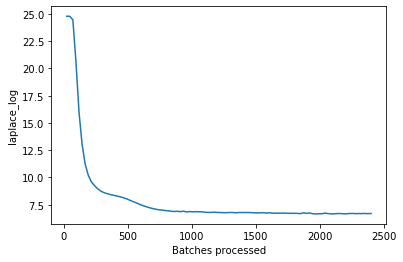

In [48]:
learn.recorder.plot_metrics()

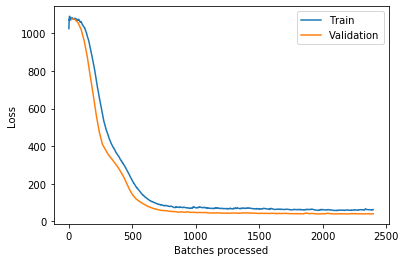

In [49]:
learn.recorder.plot_losses()

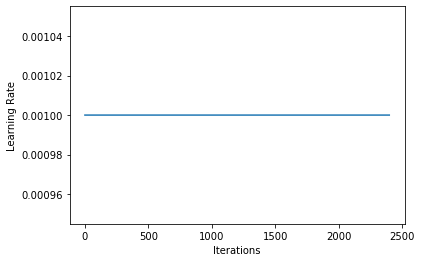

In [50]:
learn.recorder.plot_lr()

In [73]:
def get_last_metric(recorder):
    return recorder.metrics[-1][0].item()

get_last_metric(learn.recorder)

6.803339958190918

#### Training

In [111]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)
EPOCHS=100

In [102]:
def convert_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32).to(device)

In [103]:
submission_patients = submission_df['Patient']
submission_df['dummy_FVC'] = 0.0

In [104]:
submission_dl = create_dl(submission_df[FE], pd.Series(np.zeros(submission_df[FE].shape[0])))

In [105]:
x_sample, y_sample = next(iter(submission_dl))
x_sample.shape, y_sample.shape

(torch.Size([128, 9]), torch.Size([128]))

In [106]:
pe = np.zeros((submission_df.shape[0], 3))
pred = np.zeros((train_df.shape[0], 3))
pred.shape

(1542, 3)

In [107]:
test_values = convert_to_tensor(submission_df[FE])
test_values.shape

torch.Size([730, 9])

In [108]:
def predict(features, model):
    return model(features).detach().cpu().numpy()

In [116]:
%%time

recorders = []
for cnt, (tr_idx, val_idx) in tqdm(enumerate(kf.split(X)), total=NFOLD):
    X_train, y_train = X.loc[tr_idx], y[tr_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    print(f"FOLD {cnt}", X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    model = create_model()
    train_ds = ArrayDataset(X_train, y_train)
    valid_ds = ArrayDataset(X_valid, y_valid)
    learn = Learner(DataBunch.create(train_ds, valid_ds), model, loss_func=criterion, metrics=laplace_log, silent=True)
    learn.fit(EPOCHS, LR, callbacks=[fastai.callbacks.OneCycleScheduler(lr_max = LR * 4, learn=learn)])
    recorders.append(learn.recorder)
    pred[val_idx] = predict(convert_to_tensor(X_valid), model)

FOLD 0 (1233, 9) (1233,) (309, 9) (309,)


FOLD 1 (1233, 9) (1233,) (309, 9) (309,)


FOLD 2 (1234, 9) (1234,) (308, 9) (308,)


FOLD 3 (1234, 9) (1234,) (308, 9) (308,)


FOLD 4 (1234, 9) (1234,) (308, 9) (308,)



CPU times: user 53.1 s, sys: 3min 59s, total: 4min 52s
Wall time: 5min 15s


In [118]:
print("Mean validation score:", np.array([get_last_metric(recorder) for recorder in recorders]).mean())

Mean validation score: 6.753117084503174


In [112]:
torch.optim.AdamW

['ActivationStats',
 'CSVLogger',
 'EarlyStoppingCallback',
 'FlatCosAnnealScheduler',
 'GeneralScheduler',
 'Hook',
 'HookCallback',
 'Hooks',
 'LRFinder',
 'LossMetrics',
 'MixUpCallback',
 'MixUpLoss',
 'MixedPrecision',
 'OneCycleScheduler',
 'OverSamplingCallback',
 'RNNTrainer',
 'ReduceLROnPlateauCallback',
 'SaveModelCallback',
 'TerminateOnNaNCallback',
 'TrackEpochCallback',
 'TrackerCallback',
 'TrainingPhase',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'csv_logger',
 'dummy_batch',
 'dummy_eval',
 'flat_cos_anneal',
 'fp16',
 'general_sched',
 'hook_output',
 'hook_outputs',
 'hooks',
 'loss_metrics',
 'lr_finder',
 'mixup',
 'model_sizes',
 'model_summary',
 'num_features_model',
 'one_cycle',
 'oversampling',
 'rnn',
 'tracker']

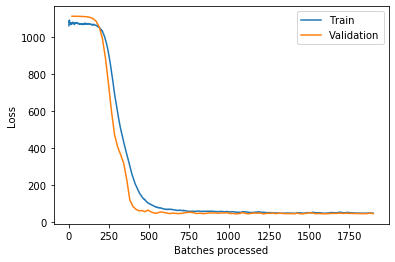

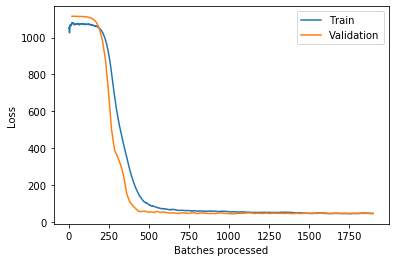

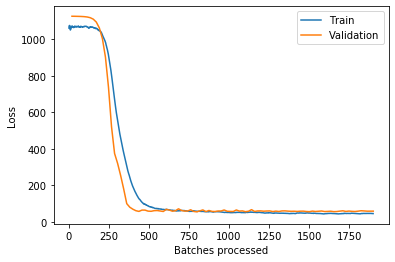

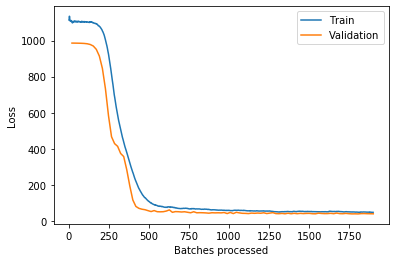

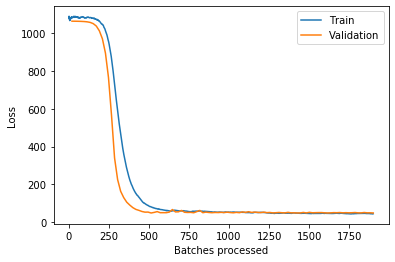

In [96]:
for recorder in recorders:
    recorder.plot_losses()

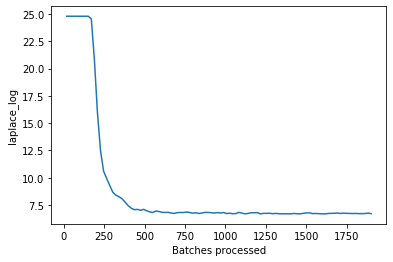

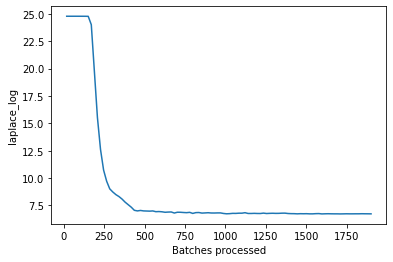

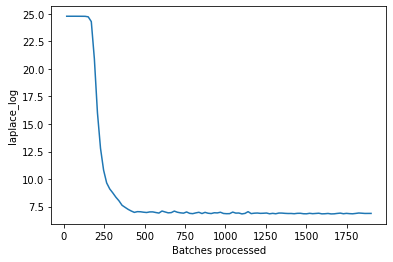

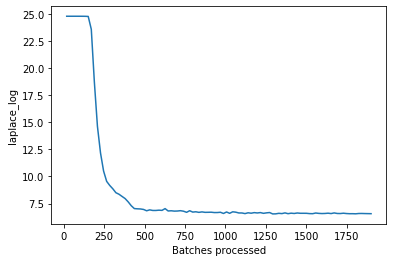

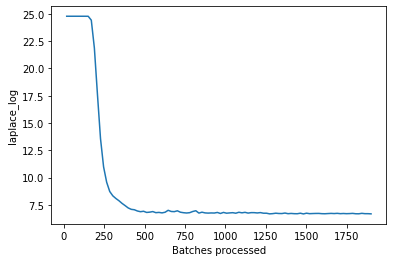

In [97]:
for recorder in recorders:
    recorder.plot_metrics()

In [ ]:
def load_best_model(i):
    model_file = model_path/f'best_model_simple_{i}.pt'
    model = create_model()
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()
    return model

In [ ]:
# Using best models for prediction
pe = np.zeros((submission_df.shape[0], 3))
for i in range(NFOLD):
    model = load_best_model(i)
    pe += predict(test_values, model)
pe = pe / NFOLD

#### Prediction

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
sigma_opt, sigma_mean

In [ ]:
submission_df['FVC1'] = pe[:,1]
submission_df['Confidence1'] = pe[:, 2] - pe[:, 0]

In [ ]:
submission_df.head(15)

In [ ]:
subm = submission_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].shape, subm.shape

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

In [ ]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.describe().T

In [ ]:
def replace_with_existing(df):
    for i in range(len(df)):
        patient_week_filter = subm['Patient_Week']==df.Patient[i]+'_'+str(df.Weeks[i])
        subm.loc[patient_week_filter, 'FVC'] = df.FVC[i]
        subm.loc[patient_week_filter, 'Confidence'] = 0.1

train_df = pd.read_csv(path/'train.csv', dtype = common.TRAIN_TYPES)
test_df = pd.read_csv(path/'test.csv', dtype = common.TRAIN_TYPES)
replace_with_existing(train_df)
replace_with_existing(test_df)

In [ ]:
subm[subm['Patient_Week'].str.find('ID00419637202311204720264') > -1].head(30)

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [ ]:
submission_final_df = pd.read_csv('submission.csv')

In [ ]:
submission_final_df[submission_final_df['Patient_Week'].str.find('ID00419637202311204720264') == 0]['FVC'].plot()

In [ ]:
submission_final_df[submission_final_df['Patient_Week'].str.find('ID00421637202311550012437') == 0]['FVC'].plot()

In [ ]:
submission_final_df[submission_final_df['Patient_Week'].str.find('ID00423637202312137826377') == 0]['FVC'].plot()

In [ ]:
train_df[train_df['Patient'].str.find('ID00419637202311204720264') == 0][['Weeks', 'FVC']].plot(x='Weeks', y='FVC')

In [ ]:
!cat submission.csv